In [1]:
import os
import glob
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
da_scores = {}
for path in glob.glob(os.path.join(RESULTS_PATH, f'scores_multi{CAF_DOSE}', '*')):
    with open(path, 'rb') as file:
        data = pickle.load(file)
        electrode = int(path.split(os.sep)[-1].split('.')[0].split('_')[-1])
        for stage in STAGES:
            for clf in data[stage].keys():
                if stage not in da_scores:
                    da_scores[stage] = {}
                if clf not in da_scores[stage]:
                    da_scores[stage][clf] = [0] * 20
                    
                if clf == 'ensemble':
                    da_scores[stage][clf][electrode] = (data[stage][clf], 1)
                else:
                    da_scores[stage][clf][electrode] = data[stage][clf]

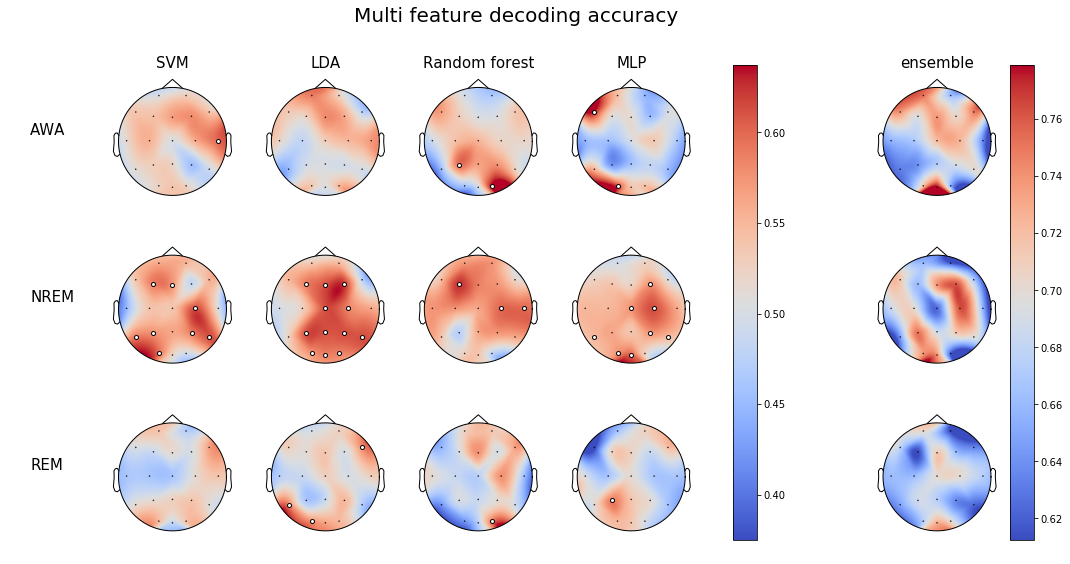

In [5]:
colormap = 'coolwarm'
small_font = 15
big_font = 20

vmin_clf = np.min([[[np.min(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys() if not clf == 'ensemble'] for stage in STAGES])
vmax_clf = np.max([[[np.max(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys() if not clf == 'ensemble'] for stage in STAGES])
vmin_ensemble = np.min([[[np.min(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys() if clf == 'ensemble'] for stage in STAGES])
vmax_ensemble = np.max([[[np.max(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys() if clf == 'ensemble'] for stage in STAGES])

plt.figure(figsize=(18, 8))
suptitle = plt.suptitle('Multi feature decoding accuracy', fontsize=big_font, y=1.05)

subplot_counter = 0
gs = gridspec.GridSpec(len(STAGES), len(da_scores[stage]) + 1, width_ratios=[0.3] + [1] * len(da_scores[stage]))

axes_clf = []
axes_ensemble = []
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    plt.annotate(stage.replace('AWSL', 'AWA'), xy=(0, 0.5), fontsize=small_font)
    plt.axis('off')
    subplot_counter += 1
    
    for clf in da_scores[stage].keys():
        acc = [score[0] for score in da_scores[stage][clf]]
        p_val = np.array([score[1] for score in da_scores[stage][clf]])
        mask = p_val < SIGNIFICANT_P
        
        if clf == 'ensemble':
            axes_ensemble.append(plt.subplot(gs[subplot_counter]))
        else:
            axes_clf.append(plt.subplot(gs[subplot_counter]))
        
        if stage == STAGES[0]:
            plt.title(clf.replace('MultilayerPerceptron', 'MLP').replace('RandomForest', 'Random forest'), fontsize=small_font)
        
        if clf == 'ensemble':
            viz.plot_topomap(acc, sensor_pos, mask=mask, vmin=vmin_ensemble, vmax=vmax_ensemble, cmap=colormap, contours=False, show=False)
        else:
            viz.plot_topomap(acc, sensor_pos, mask=mask, vmin=vmin_clf, vmax=vmax_clf, cmap=colormap, contours=False, show=False)
        subplot_counter += 1

# classifier colorbar
norm = colors.Normalize(vmin=vmin_clf, vmax=vmax_clf)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes_clf, shrink=1, aspect=20)

# ensemble colorbar
norm = colors.Normalize(vmin=vmin_ensemble, vmax=vmax_ensemble)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes_ensemble, shrink=1, aspect=20)

plt.savefig(os.path.join(FIGURE_PATH, 'decodingAccuracyMulti', f'decodingAccuracy{CAF_DOSE}'), bbox_inches='tight', bbox_extra_artists=[suptitle])
plt.show()